In [1]:
!source activate py377

/bin/bash: activate: No such file or directory


In [1]:
import numpy as np
import pandas as pd
import h5py as h5
import keras
import sklearn
import matplotlib.pyplot as plt
# import datashader as ds
# import datashader.transfer_functions as ds_tf
import IPython
import holoviews as hv
import random
hv.extension('bokeh')

from bokeh.io import output_file, save, show
from holoviews import opts
# from holoviews.operation.datashader import datashade, dynspread

from IPython.display import display

import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings("ignore")
import sys
#import os

from sklearn.multioutput import MultiOutputClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score, precision_recall_curve, accuracy_score, confusion_matrix  
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split

import pickle

print("Python version:\n{}\n".format(sys.version))
# print("matplotlib version: {}".format(plt.__version__))
print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("sklearn version: {}".format(sklearn.__version__))
print("keras version: {}".format(keras.__version__))

Output hidden; open in https://colab.research.google.com to view.

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May 11 01:44:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


data gen

In [4]:
# load and format raw data
def load_ppg(data):
    signal_data = data['signal']
    # squeeze out extra dimension padding
    signal_data = np.squeeze(signal_data, axis=-1)
    print(len(signal_data[0]))
    
    return signal_data;

# return holoviews curve
def convert_curve(raw_data, num_signals=1):
    signals = {}
    for sig_idx in range(0, num_signals):
        temp_sig = raw_data[sig_idx, :]

        ts_sig = hv.Curve(temp_sig, label=str(sig_idx))
        signals[sig_idx] = ts_sig

    all_sigs = signals[0];
    for sig_idx in range(0, num_signals):
        curr_sig = signals[sig_idx]
        all_sigs *= curr_sig

    return all_sigs


def web_graph(signals, web_page='graph.html'):
    # # output_signals = (all_sigs).opts(title='test_signals: {}'.format(10))
    # # (datashade(output_signals)).options(width=1000, axiswise=True)
    signals.opts(
    opts.Curve( height=600, width=1000, tools=['hover']),
    )

    renderer = hv.renderer('bokeh')

    # Using renderer save
    renderer.save(signals, web_page)

    # Convert to bokeh figure then save using bokeh
    plot = renderer.get_plot(signals).state

    save(plot, web_page)

def graph(signals, web_page='graph.html'):
    # # output_signals = (all_sigs).opts(title='test_signals: {}'.format(10))
    # # (datashade(output_signals)).options(width=1000, axiswise=True)
    signals.opts(
    opts.Curve( height=600, width=1000, tools=['hover']),
    )

    display(signals)

# modulate noise per signal
def modulate_noise(noise, window=4):
    noise_toret = np.zeros(noise.shape[0], dtype=float)
    idx = 0
    while (idx < noise.shape[0]):
        rand = random.randint(0, 100)
        if(rand >= 60):
            noise_toret[idx:idx+window] = noise.squeeze()[idx:idx+window]
            idx+=window
        else:
            idx+=window
        
    return noise_toret

def gen_noise(signal_data, num_signals=1):
    # Set a target SNR
    noises = []
    for idx in range(0,num_signals):
        target_snr_db = 24
        
        raw_mean = np.mean(signal_data[idx, :])
        if raw_mean==0: print('broken noise gen')
        
        sig_avg_db = 10 * np.log10(raw_mean)
        
        # Calculate noise according to [2] then convert to watts
        noise_avg_db = sig_avg_db - target_snr_db
        noise_avg_ppg = 10 ** (noise_avg_db / 10)

        noise_snr = np.random.normal(0, np.sqrt(noise_avg_ppg), 800)
        noises.append(noise_snr)
        
    return np.asarray(noises)

#### Different SNR noises

# https://stackoverflow.com/questions/14058340/adding-noise-to-a-signal-in-python
def snr1(signal, target_snr=20):
    raw_mean = np.mean(signal_data[idx, :])
    sig_avg_db = 10 * np.log10(raw_mean)

    # Calculate noise according to [2] then convert to watts
    noise_avg_db = sig_avg_db - target_snr
    noise_avg_ppg = 10 ** (noise_avg_db / 10)

    noise_snr = np.random.normal(0, np.sqrt(noise_avg_ppg), 800)
    
    return noise_snr




def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)
    
def remove_na(data):
    nans_idx = []
    nan_count=0
    for row_idx in range(0, len(data)):
        curr_sig = data[row_idx,:]
        if np.isnan(curr_sig).any():
            nan_count+=1
            nans_idx.append(row_idx)
    
    return nans_idx

In [5]:
# load and format raw data
def load_ppg(data):
    signal_data = data['signal']
    # squeeze out extra dimension padding
    signal_data = np.squeeze(signal_data, axis=-1)
    print(len(signal_data[0]))
    
    return signal_data;

# modulate noise per signal
def modulate_noise(noise, window=4):
    noise_toret = np.zeros(noise.shape[0], dtype=float)
    idx = 0
    while (idx < noise.shape[0]):
        rand = random.randint(0, 100)
        if(rand >= 60):
            noise_toret[idx:idx+window] = noise.squeeze()[idx:idx+window]
            idx+=window
        else:
            idx+=window
        
    return noise_toret

def gen_noise(signal_data, num_signals=1):
    # Set a target SNR
    noises = []
    for idx in range(0,num_signals):
        target_snr_db = 24
        
        raw_mean = np.mean(signal_data[idx, :])
        if raw_mean==0: print('broken noise gen')
        
        sig_avg_db = 10 * np.log10(raw_mean)
        
        # Calculate noise according to [2] then convert to watts
        noise_avg_db = sig_avg_db - target_snr_db
        noise_avg_ppg = 10 ** (noise_avg_db / 10)

        noise_snr = np.random.normal(0, np.sqrt(noise_avg_ppg), 800)
        noises.append(noise_snr)
        
    return np.asarray(noises)

def graph(signals, web_page='graph.html'):
    # # output_signals = (all_sigs).opts(title='test_signals: {}'.format(10))
    # # (datashade(output_signals)).options(width=1000, axiswise=True)
    signals.opts(
    opts.Curve( height=600, width=1000, tools=['hover']),
    )

    display(signals)
    
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

In [ ]:
data = np.load('/content/drive/MyDrive/Colab Notebooks/pulse.npz', allow_pickle=True)
lst = data.files
print
# Data features: signal, qa_label, rhythm (AF/non-af Label?), parameters
#### load data
# signal_data = load_ppg(data)
# qa_labels = data['qa_label']
# af_labels = data['rhythm']

signal_data = data['ppg']
qa_labels = data['qa_labels']
af_labels = data['af_labels']

# signal_data = np.asarray(signal_data)
# signal_data = signal_data[1400000:,]
# af_labels = np.asarray(af_labels)
# af_labels = af_labels[1400000:,]
# qa_labels = np.asarray(qa_labels)
# qa_labels = qa_labels[1400000:,]

# params_df = pd.DataFrame(data['parameters'])
# params_df.rename(columns = {0: 'ts',
#                             1: 'stream',
#                             2: 'ID'}, inplace=True)
# params_df.reset_index()
# params_df.groupby(['stream', 'ID']).head()
# np.savez('/content/drive/MyDrive/Colab Notebooks/pulse.npz', ppg=signal_data, af_labels=af_labels, qa_labels=qa_labels)




In [ ]:
np.savez('/content/drive/MyDrive/Colab Notebooks/pulse.npz', ppg=signal_data, af_labels=af_labels, qa_labels=qa_labels)
print((signal_data.shape))

(1403934, 800)


In [ ]:
nans_idx = remove_na(signal_data)

signal_data = np.delete(signal_data, nans_idx, axis=0)
af_labels = np.delete(af_labels, nans_idx, axis=0)
qa_labels = np.delete(qa_labels, nans_idx, axis=0)

# print('{} nan rows removed'.format(2803934 - len(signal_data)))
print('{} nan rows removed'.format(1403934 - len(signal_data))) #pulse.npz
# print('{} nan rows removed'.format(18000 - len(signal_data_og)))

1404150 nan rows removed


In [ ]:
print('{} nan rows removed'.format(1403934 - len(signal_data)))

4150 nan rows removed


#### save the data for cdae use

In [ ]:
## split half for cdae and half for pulse_model, and then resplit for train/test data
## ensure dataset has atleast X% of postive AF labels

cdae_x, pulse_x, cdae_y_af, pulse_y_af = train_test_split(signal_data, af_labels, test_size=0.5, random_state=21)
cdae_x, pulse_x, cdae_y_qa, pulse_y_qa = train_test_split(signal_data, qa_labels, test_size=0.5, random_state=21)

print(np.sum(pulse_y_af[:, 1]))

np.savez('data/cdae.npz', cdae_x=cdae_x, cdae_y_af=cdae_y_af, cdae_y_qa=cdae_y_qa)
np.savez('data/pulse.npz', pulse_x=pulse_x, pulse_y_af=pulse_y_af, pulse_y_qa=pulse_y_qa)

Load saved data

In [ ]:
model = 'pulse'
# pulse = np.load('/content/drive/MyDrive/Colab Notebooks/{0}.npz'.format(model), allow_pickle=True)
# print(pulse.files)
# pulse_x = pulse['{}_x'.format(model)]
# pulse_y_af = pulse['{}_y_af'.format(model)]
# pulse_y_qa = pulse['{}_y_qa'.format(model)]

# pulse_x = pulse['ppg']
# pulse_y_af = pulse['af_labels']
# pulse_y_qa = pulse['qa_labels']

pulse_x = signal_data
pulse_y_af = af_labels
pulse_y_qa = qa_labels

x_train, x_test, y_train_af, y_test_af = train_test_split(pulse_x, pulse_y_af, test_size=0.3, random_state=7)
x_train, x_test, y_train_qa, y_test_qa = train_test_split(pulse_x, pulse_y_qa, test_size=0.3, random_state=7)

x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
print('x_train shape is still', x_train.shape)

x_train shape is still (979848, 800, 1)


## Load PULSE data

In [11]:
x_train = np.load('/content/drive/MyDrive/Colab Notebooks/PULSE_x_train.npz', allow_pickle=True)
x_test = np.load('/content/drive/MyDrive/Colab Notebooks/PULSE_x_test.npz', allow_pickle=True)
y_train_af = np.load('/content/drive/MyDrive/Colab Notebooks/PULSE_y_train_af.npz', allow_pickle=True)
y_train_qa = np.load('/content/drive/MyDrive/Colab Notebooks/PULSE_y_train_qa.npz', allow_pickle=True)
y_test_af = np.load('/content/drive/MyDrive/Colab Notebooks/PULSE_y_test_af.npz', allow_pickle=True)
y_test_qa = np.load('/content/drive/MyDrive/Colab Notebooks/PULSE_y_test_qa.npz', allow_pickle=True)

cdae_y_test = np.load('/content/drive/MyDrive/Colab Notebooks/CDAE_y_test.npz', allow_pickle=True)
cdae_y_train = np.load('/content/drive/MyDrive/Colab Notebooks/CDAE_y_train.npz', allow_pickle=True)

x_train=x_train['x_train']
x_test=x_test['x_test']
y_train_af=y_train_af['y_train_af']
y_train_qa=y_train_qa['y_train_qa']
y_test_af=y_test_af['y_test_af']
y_test_qa=y_test_qa['y_test_qa']

cdae_y_test = cdae_y_test['y_test']
cdae_y_train = cdae_y_train['y_train']
# np.savez('/content/drive/MyDrive/Colab Notebooks/PULSE_x_train.npz', x_train=x_train)
# np.savez('/content/drive/MyDrive/Colab Notebooks/PULSE_x_test.npz', x_test=x_test)

# np.savez('/content/drive/MyDrive/Colab Notebooks/PULSE_y_train_af.npz', y_train_af=y_train_af)
# np.savez('/content/drive/MyDrive/Colab Notebooks/PULSE_y_train_qa.npz', y_train_qa=y_train_qa)
# np.savez('/content/drive/MyDrive/Colab Notebooks/PULSE_y_test_af.npz', y_test_af=y_test_af)
# np.savez('/content/drive/MyDrive/Colab Notebooks/PULSE_y_test_qa.npz', y_test_qa=y_test_qa)

In [24]:
x_test.shape

(419936, 800, 1)

pulse+pretraining model stuff

In [8]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Conv2DTranspose, BatchNormalization, Flatten, Reshape, Lambda, LeakyReLU, Dropout

# The encoding process
input_sig = Input(shape=(800, 1))  
depth = 1
############
# Encoding #
############

# Conv1 #
x = Conv1D(filters = 32, kernel_size = (10), padding='same')(input_sig)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPooling1D(pool_size = 3, padding='same')(x)
# x = BatchNormalization(axis=-1)(x)

# Conv2 #
x = Conv1D(filters = 20, kernel_size = (8), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPooling1D(pool_size = 3, padding='same')(x) 
# x = BatchNormalization(axis=-1)(x)

# Conv 3 #
x = Conv1D(filters = 25, kernel_size = (5), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPooling1D(pool_size = 2, padding='same')(x)

# END OF TRANSFER LEARNED LAYERS
# batch normalize after end of transfer learning layers

## SHARED LEARNING
last_conv = BatchNormalization(axis=-1)(x)
x = Conv1D(filters = 64, kernel_size=(4), strides=3, padding='same')(last_conv)
x = LeakyReLU(alpha=0.15)(x)

x = BatchNormalization(axis=-1)(x)
x = Dropout(0.1)(x)
x = Conv1D(filters=35, kernel_size=(4), strides=3)(x)
x = LeakyReLU(alpha=0.15)(x)

x = BatchNormalization(axis=-1)(x)
x = Dropout(0.1)(x)
x = Conv1D(filters = 64, kernel_size=(4), padding='same')(x)
x = LeakyReLU(alpha=0.15)(x)
    
x = BatchNormalization(axis=-1)(x)
fin = Dropout(0.1)(x)

## MULTI-TASK

# af/non-af classification
a = Conv1D(filters=35, kernel_size=(5), activation='relu', padding='same', strides=3)(fin)
a = BatchNormalization(axis=-1)(a)
a = Dropout(0.1)(a)

a = Conv1D(filters=25, kernel_size=(1), activation='relu', padding='same', strides=2)(a)
a = BatchNormalization(axis=-1)(a)
a = Dropout(0.1)(a)

a = Conv1D(filters=35, kernel_size=(2), activation='relu', padding='same')(a)
a = BatchNormalization(axis=-1)(a)
a = Dropout(0.1)(a)

a = Flatten()(a)
a = Dense(175)(a)
af_output = Dense(2, activation='sigmoid', name='af_output')(a)


# qa classification
b = Conv1D(filters=25, kernel_size=(2), activation='relu', padding='same', strides=2)(fin)
b = BatchNormalization(axis=-1)(b)
b = Dropout(0.1)(b)

b = Flatten()(b)
b = Dense(175)(b)
qa_output = Dense(3, activation='softmax', name='qa_output')(b)


In [9]:
import h5py as h5
import numpy as np
import pandas as pd
import random

import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import holoviews as hv
hv.extension('bokeh')

from bokeh.io import output_file, save, show
from holoviews import opts
# from holoviews.operation.datashader import datashade, dynspread

# import umap
import tensorflow
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

pulse_model = Model(inputs=input_sig,
                    outputs=[af_output, qa_output])

weights_biases = np.load('/content/drive/MyDrive/Colab Notebooks/encode_weights.npy', allow_pickle=True)

print(type(weights_biases[0][0]))
pulse_model.layers[1].set_weights(weights_biases[0])
pulse_model.layers[4].set_weights(weights_biases[1])
pulse_model.layers[7].set_weights(weights_biases[2])

# pulse_model.layers[1].trainable = False
# pulse_model.layers[4].trainable = False
# pulse_model.layers[7].trainable = False

Output hidden; open in https://colab.research.google.com to view.

In [21]:
opt = Adam(learning_rate=1e-3)

# mse
losses = {
    "af_output": "mse",
    "qa_output": "mse",
    }
    
pulse_model.compile(optimizer=opt,
                   loss=losses,
#                    metrics=['sparse_categorical_accuracy']
                   )

fresh_weights = pulse_model.get_weights()

pulse_model.summary()

# plot_model(pulse_model, to_file='pulse_model_pretrained.png', show_shapes=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 800, 1)]     0           []                               
                                                                                                  
 conv1d_10 (Conv1D)             (None, 800, 32)      352         ['input_2[0][0]']                
                                                                                                  
 leaky_re_lu_6 (LeakyReLU)      (None, 800, 32)      0           ['conv1d_10[0][0]']              
                                                                                                  
 max_pooling1d_3 (MaxPooling1D)  (None, 267, 32)     0           ['leaky_re_lu_6[0][0]']          
                                                                                            

In [22]:
# %%capture output

EPOCHS=100 #200
BS=128 #128

# pulse_model.set_weights(fresh_weights)
# print(x_test.shape)

H = pulse_model.fit(x_train, {'af_output':y_train_af, 'qa_output':y_train_qa},
                    epochs=EPOCHS,
                    batch_size=BS,
                    shuffle=True,
                    validation_data=(x_test, {'af_output':y_test_af, 'qa_output':y_test_qa})
#                     validation_split=0.2
                   )

# pulse_model.save('models/pulse_pre.h5')


Epoch 1/100
7656/7656 [==============================] - 98s 13ms/step - loss: 0.0810 - af_output_loss: 0.0490 - qa_output_loss: 0.0320 - val_loss: 0.1035 - val_af_output_loss: 0.0542 - val_qa_output_loss: 0.0493
Epoch 2/100
7656/7656 [==============================] - 93s 12ms/step - loss: 0.0648 - af_output_loss: 0.0386 - qa_output_loss: 0.0262 - val_loss: 0.1650 - val_af_output_loss: 0.1400 - val_qa_output_loss: 0.0250
Epoch 3/100
7656/7656 [==============================] - 93s 12ms/step - loss: 0.0607 - af_output_loss: 0.0359 - qa_output_loss: 0.0247 - val_loss: 0.0682 - val_af_output_loss: 0.0399 - val_qa_output_loss: 0.0282
Epoch 4/100
7656/7656 [==============================] - 94s 12ms/step - loss: 0.0584 - af_output_loss: 0.0345 - qa_output_loss: 0.0238 - val_loss: 0.0753 - val_af_output_loss: 0.0372 - val_qa_output_loss: 0.0382
Epoch 5/100
7656/7656 [==============================] - 93s 12ms/step - loss: 0.0566 - af_output_loss: 0.0335 - qa_output_loss: 0.0230 - val_loss: 

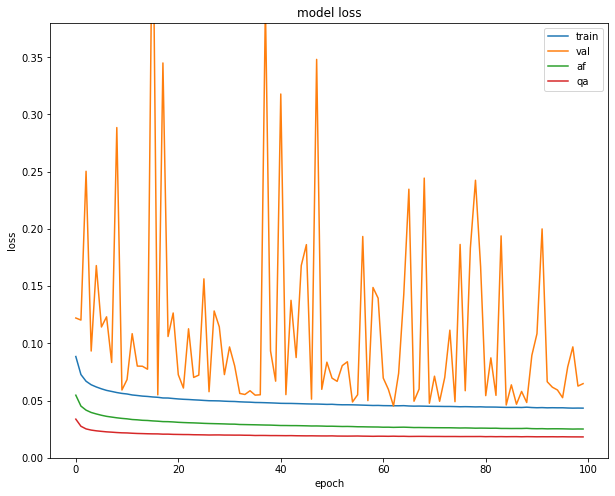

In [19]:
plt.figure(figsize=(10,8))
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.plot(H.history['af_output_loss'])
plt.plot(H.history['qa_output_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.ylim((0,0.38))
plt.xlabel('epoch')
plt.legend(['train', 'val', 'af', 'qa'], loc='upper right')
plt.show()

In [18]:
pulse_model.save('/content/drive/MyDrive/Colab Notebooks/pulse_pre_1.h5')

In [ ]:
from keras.models import load_model
from keras.models import Model


pulse_model = load_model('/content/drive/MyDrive/Colab Notebooks/deepbeat.h5')
pulse2 = Model(inputs=pulse_model.input, outputs=pulse_model.output)
pulse_model.summary()

#Results

In [35]:
# try using cdae_y_train/cdae_y_test
import time

start = time.time()
predictions_r0, predictions_qa0 = pulse_model.predict(cdae_y_test)
end = time.time()
print('time taken ', end-start)

predictions_QA = np.argmax(predictions_qa0, axis=1)
print(predictions_qa0.shape)
excellent_qa_indx = np.where(((predictions_QA==2) | (predictions_QA==1)))[0]

#good or excellent signals only
x_test_excellent = x_test[excellent_qa_indx,:]
rhythm_test_excellent = y_test_af[excellent_qa_indx,:]
quality_assessment_test_excellent = y_test_qa[excellent_qa_indx,:]

#ALL test signals
# x_test_excellent = x_test
# rhythm_test_excellent = y_test_af
# quality_assessment_test_excellent = y_test_qa

predictions_r, predictions_qa = pulse_model.predict(x_test_excellent)

# r2, q2 = pulse2.predict(x_test)
# predictions_qa, predictions_r = deepbeat.predict(x_test)

print(predictions_qa.shape)

time taken  8.303199291229248
(70992, 2)
(137, 2)


In [29]:
y_predictions = np.argmax(predictions_r, axis=1)
# y_predictions = np.argmax(r2, axis=1)
y_truth = np.argmax(rhythm_test_excellent, axis=1)

# Confusion_matrix
cf = confusion_matrix(y_truth, y_predictions)
TN, FP, FN, TP = cf.ravel()
print('recall', TP/(TP+FN))
print('ppv', TN/(TN+FN))
# cf
print(FP/(FP+TN))
print(FN/(FN+TP))
print(TP/(TP+FP))

recall 0.9992792679869642
ppv 0.9880114672921553
0.4212213740458015
0.0007207320130358486
0.9585343493094068


In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
# # r_probs = r_probs.ravel()
# print(r_probs.shape)
fpr_keras_af, tpr_keras_af, thresholds_keras_af = roc_curve(rhythm_test_excellent[:,1], predictions_r[:,1])
auc_keras_af = auc(fpr_keras_af, tpr_keras_af)

fpr_keras_qa, tpr_keras_qa, thresholds_keras_qa = roc_curve(quality_assessment_test_excellent[:,1], predictions_qa[:,1])
auc_keras_qa = auc(fpr_keras_qa, tpr_keras_qa)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_qa, tpr_keras_qa, label='Pulse AF (area = {:.3f})'.format(auc_keras_qa))
plt.plot(fpr_keras_af, tpr_keras_af, label='Pulse QA (area = {:.3f})'.format(auc_keras_af))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [27]:
y_predictions = np.argmax(predictions_r, axis=1)
# y_predictions = np.argmax(r2, axis=1)
y_truth = np.argmax(rhythm_test_excellent, axis=1)

# Confusion_matrix
cf = confusion_matrix(y_truth, y_predictions)
TN, FP, FN, TP = cf.ravel()
print('recall', TP/(TP+FN))
print('ppv', TN/(TN+FN))
# cf
print(FP/(FP+TN))
print(FN/(FN+TP))
print(TP/(TP+FP))

recall 0.9992619034485657
ppv 0.9877788892271561
0.421011038315446
0.0007380965514342976
0.9583945301970308


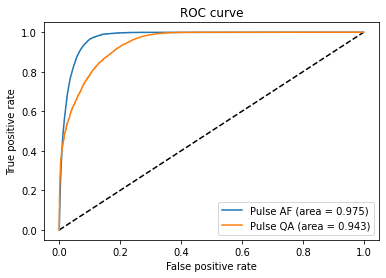

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
# # r_probs = r_probs.ravel()
# print(r_probs.shape)
fpr_keras_af, tpr_keras_af, thresholds_keras_af = roc_curve(rhythm_test_excellent[:,1], predictions_r[:,1])
auc_keras_af = auc(fpr_keras_af, tpr_keras_af)

fpr_keras_qa, tpr_keras_qa, thresholds_keras_qa = roc_curve(quality_assessment_test_excellent[:,1], predictions_qa[:,1])
auc_keras_qa = auc(fpr_keras_qa, tpr_keras_qa)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_qa, tpr_keras_qa, label='Pulse AF (area = {:.3f})'.format(auc_keras_qa))
plt.plot(fpr_keras_af, tpr_keras_af, label='Pulse QA (area = {:.3f})'.format(auc_keras_af))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()